In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 1
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [2]:
xmin = -0.5
xmax = 1
ymin = -0.5
ymax = 1.5
N = 50
N_bc = 80
Re = 10
nu = 1 / Re
lamb = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

In [3]:
dx = (xmax-xmin)/(N_bc)
dy = (ymax-ymin)/(N_bc)
x_data = np.arange(xmin+dx, xmax, dx)
y_data = np.arange(ymin+dy, ymax, dy)
#print(dx)
#print(dy)
#print("X_data: ", x_data)
#print("Y_data: ", y_data)

x = []
y = []
x.append(xmin)
y.append(ymin)
x.append(xmin)
y.append(ymax)
x.append(xmax)
y.append(ymin)
x.append(xmax)
y.append(ymax)
for i in range(N_bc-1):
    x.append(xmin)
    y.append(y_data[i])
    x.append(xmax)
    y.append(y_data[i])
    x.append(x_data[i])
    y.append(ymin)
    x.append(x_data[i])
    y.append(ymax)

x = np.array(x, dtype=float)
y = np.array(y, dtype=float)
X_bc = np.ndarray.reshape(x, (x.shape[0],1))
Y_bc = np.ndarray.reshape(y, (y.shape[0],1))

S_bc = np.zeros((4*N_bc, 3))
U_bc = 1-(np.exp(lamb*X_bc))*(np.cos(2*math.pi*Y_bc))
V_bc = (lamb/(2*math.pi))*(np.exp(lamb*X_bc))*(np.sin(2*math.pi*Y_bc))
P_bc = (1/2)*(1-(np.exp(2*lamb*X_bc)))
S_bc[:,0:1] = np.ndarray.reshape(U_bc, (U_bc.shape[0],1))
S_bc[:,1:2] = np.ndarray.reshape(V_bc, (V_bc.shape[0],1))
S_bc[:,2:] = np.ndarray.reshape(P_bc, (P_bc.shape[0],1))

#print("X_bc: ", X_bc.shape)
#print("Y_bc: ", Y_bc.shape)

# print("X_bc: ", x_bc)
# print("Y_bc: ", y_bc)

# for i in range(4*N):
#     print(x_bc[i], " ", y_bc[i])

In [4]:
X_bc = Variable(torch.from_numpy(X_bc).float(), requires_grad=False).to(device)
Y_bc = Variable(torch.from_numpy(Y_bc).float(), requires_grad=False).to(device)
S_bc = Variable(torch.from_numpy(S_bc).float(), requires_grad=False).to(device)

x = np.arange(xmin, xmax, (xmax-xmin)/N)
y = np.arange(ymin, ymax, (ymax-ymin)/N)
X, Y = np.meshgrid(x,y)
X = X.flatten()[:,None]
Y = Y.flatten()[:,None]
F = np.zeros_like(X)

X = Variable(torch.from_numpy(X).float(), requires_grad=True).to(device)
Y = Variable(torch.from_numpy(Y).float(), requires_grad=True).to(device)
F = Variable(torch.from_numpy(F).float(), requires_grad=True).to(device)

In [5]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layer1 = nn.Linear(2,20)
        self.layer2 = nn.Linear(20,20)
        self.layer3 = nn.Linear(20,20)
        self.layer4 = nn.Linear(20,20)
        self.layer5 = nn.Linear(20,20)
        self.layer6 = nn.Linear(20,20)
        self.output_layer = nn.Linear(20,3)

    def forward(self, x, y): 
        inputs = torch.cat([x, y], axis=1)
        layer1_out = torch.tanh(self.layer1(inputs))
        layer2_out = torch.tanh(self.layer2(layer1_out))
        layer3_out = torch.tanh(self.layer3(layer2_out))
        layer4_out = torch.tanh(self.layer4(layer3_out))
        layer5_out = torch.tanh(self.layer5(layer4_out))
        layer6_out = torch.tanh(self.layer6(layer5_out))
        output = self.output_layer(layer6_out) 
        return output

In [6]:
pinn = PINN()
pinn = pinn.to(device)
mse_cost_function = nn.MSELoss() 
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-2)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5000,10000,15000,20000,25000], gamma=0.1, last_epoch=-1, verbose=False)

In [7]:
def residual(x, y, pinn):
    s = pinn.forward(x, y)
    u = s[:,0:1]
    v = s[:,1:2]
    p = s[:,2:]

    du_dx = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    dv_dx = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    dp_dx = torch.autograd.grad(p.sum(), x, create_graph=True)[0]

    du_dy = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    dv_dy = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    dp_dy = torch.autograd.grad(p.sum(), y, create_graph=True)[0]

    du_dxx = torch.autograd.grad(du_dx.sum(), x, create_graph=True)[0]
    dv_dxx = torch.autograd.grad(dv_dx.sum(), x, create_graph=True)[0]
    du_dyy = torch.autograd.grad(du_dy.sum(), y, create_graph=True)[0]
    dv_dyy = torch.autograd.grad(dv_dy.sum(), y, create_graph=True)[0]

    f1 = u*du_dx + v*du_dy + dp_dx - nu*(du_dxx + du_dyy)
    f2 = u*dv_dx + v*dv_dy + dp_dy - nu*(dv_dxx + dv_dyy)
    f3 = du_dx + dv_dy
    f = f1 + f2 + f3
    return f

In [8]:
iterations = 50000
for epoch in range(iterations):
    optimizer.zero_grad()
    
    PINN_S_bc = pinn.forward(X_bc, Y_bc)
    MSE_U = mse_cost_function(PINN_S_bc, S_bc)

    PINN_Residual = residual(X, Y, pinn)
    MSE_F = mse_cost_function(PINN_Residual, F)

    Loss = MSE_U + MSE_F

    Loss.backward()
    optimizer.step()
    scheduler.step()

    with torch.autograd.no_grad():
        if epoch%100 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print('Epoch %d, LR: %.4e, Loss: %.4e, Data Loss: %.4e, Physics Loss: %.4e' % (epoch, current_lr, Loss, MSE_U, MSE_F))

Epoch 0, LR: 1.0000e-02, Loss: 1.1021e+01, Data Loss: 1.1021e+01, Physics Loss: 2.7280e-05


C:\Users\ameyv\anaconda3\envs\amey-pinn\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [2500, 1], strides() = [1, 0]
param.sizes() = [2500, 1], strides() = [1, 0] (Triggered internally at C:\cb\pytorch_1000000000000\work\torch/csrc/autograd/functions/accumulate_grad.h:202.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 100, LR: 1.0000e-02, Loss: 1.7156e+00, Data Loss: 1.6474e+00, Physics Loss: 6.8226e-02
Epoch 200, LR: 1.0000e-02, Loss: 1.6112e+00, Data Loss: 1.5970e+00, Physics Loss: 1.4124e-02
Epoch 300, LR: 1.0000e-02, Loss: 1.5569e+00, Data Loss: 1.5538e+00, Physics Loss: 3.1253e-03
Epoch 400, LR: 1.0000e-02, Loss: 1.5244e+00, Data Loss: 1.5214e+00, Physics Loss: 2.9186e-03
Epoch 500, LR: 1.0000e-02, Loss: 1.5372e+00, Data Loss: 1.5322e+00, Physics Loss: 4.9977e-03
Epoch 600, LR: 1.0000e-02, Loss: 1.5587e+00, Data Loss: 1.5151e+00, Physics Loss: 4.3599e-02
Epoch 700, LR: 1.0000e-02, Loss: 1.4887e+00, Data Loss: 1.4868e+00, Physics Loss: 1.8272e-03
Epoch 800, LR: 1.0000e-02, Loss: 1.4939e+00, Data Loss: 1.4910e+00, Physics Loss: 2.8759e-03
Epoch 900, LR: 1.0000e-02, Loss: 1.4640e+00, Data Loss: 1.4525e+00, Physics Loss: 1.1424e-02
Epoch 1000, LR: 1.0000e-02, Loss: 1.4570e+00, Data Loss: 1.4532e+00, Physics Loss: 3.8479e-03
Epoch 1100, LR: 1.0000e-02, Loss: 1.4611e+00, Data Loss: 1.4494e+00, 

Epoch 8900, LR: 1.0000e-03, Loss: 6.3827e-01, Data Loss: 6.1680e-01, Physics Loss: 2.1467e-02
Epoch 9000, LR: 1.0000e-03, Loss: 6.2567e-01, Data Loss: 6.0336e-01, Physics Loss: 2.2307e-02
Epoch 9100, LR: 1.0000e-03, Loss: 6.1293e-01, Data Loss: 5.8969e-01, Physics Loss: 2.3247e-02
Epoch 9200, LR: 1.0000e-03, Loss: 6.0048e-01, Data Loss: 5.7766e-01, Physics Loss: 2.2820e-02
Epoch 9300, LR: 1.0000e-03, Loss: 5.8776e-01, Data Loss: 5.6320e-01, Physics Loss: 2.4558e-02
Epoch 9400, LR: 1.0000e-03, Loss: 6.7462e-01, Data Loss: 5.4747e-01, Physics Loss: 1.2715e-01
Epoch 9500, LR: 1.0000e-03, Loss: 5.7978e-01, Data Loss: 5.3433e-01, Physics Loss: 4.5454e-02
Epoch 9600, LR: 1.0000e-03, Loss: 5.6684e-01, Data Loss: 5.1973e-01, Physics Loss: 4.7110e-02
Epoch 9700, LR: 1.0000e-03, Loss: 5.8420e-01, Data Loss: 5.0467e-01, Physics Loss: 7.9530e-02
Epoch 9800, LR: 1.0000e-03, Loss: 5.2671e-01, Data Loss: 4.8962e-01, Physics Loss: 3.7095e-02
Epoch 9900, LR: 1.0000e-03, Loss: 5.5561e-01, Data Loss: 4.7

Epoch 17600, LR: 1.0000e-05, Loss: 2.6705e-01, Data Loss: 2.4117e-01, Physics Loss: 2.5876e-02
Epoch 17700, LR: 1.0000e-05, Loss: 2.6589e-01, Data Loss: 2.4007e-01, Physics Loss: 2.5827e-02
Epoch 17800, LR: 1.0000e-05, Loss: 2.6471e-01, Data Loss: 2.3893e-01, Physics Loss: 2.5775e-02
Epoch 17900, LR: 1.0000e-05, Loss: 2.6350e-01, Data Loss: 2.3778e-01, Physics Loss: 2.5720e-02
Epoch 18000, LR: 1.0000e-05, Loss: 2.6226e-01, Data Loss: 2.3659e-01, Physics Loss: 2.5665e-02
Epoch 18100, LR: 1.0000e-05, Loss: 2.6099e-01, Data Loss: 2.3538e-01, Physics Loss: 2.5608e-02
Epoch 18200, LR: 1.0000e-05, Loss: 2.5968e-01, Data Loss: 2.3414e-01, Physics Loss: 2.5547e-02
Epoch 18300, LR: 1.0000e-05, Loss: 2.5836e-01, Data Loss: 2.3287e-01, Physics Loss: 2.5486e-02
Epoch 18400, LR: 1.0000e-05, Loss: 2.5700e-01, Data Loss: 2.3157e-01, Physics Loss: 2.5423e-02
Epoch 18500, LR: 1.0000e-05, Loss: 2.5561e-01, Data Loss: 2.3025e-01, Physics Loss: 2.5358e-02
Epoch 18600, LR: 1.0000e-05, Loss: 2.5419e-01, Dat

Epoch 26300, LR: 1.0000e-07, Loss: 2.2045e-01, Data Loss: 1.9680e-01, Physics Loss: 2.3646e-02
Epoch 26400, LR: 1.0000e-07, Loss: 2.2042e-01, Data Loss: 1.9677e-01, Physics Loss: 2.3645e-02
Epoch 26500, LR: 1.0000e-07, Loss: 2.2038e-01, Data Loss: 1.9674e-01, Physics Loss: 2.3643e-02
Epoch 26600, LR: 1.0000e-07, Loss: 2.2035e-01, Data Loss: 1.9671e-01, Physics Loss: 2.3642e-02
Epoch 26700, LR: 1.0000e-07, Loss: 2.2032e-01, Data Loss: 1.9668e-01, Physics Loss: 2.3640e-02
Epoch 26800, LR: 1.0000e-07, Loss: 2.2029e-01, Data Loss: 1.9665e-01, Physics Loss: 2.3638e-02
Epoch 26900, LR: 1.0000e-07, Loss: 2.2026e-01, Data Loss: 1.9662e-01, Physics Loss: 2.3637e-02
Epoch 27000, LR: 1.0000e-07, Loss: 2.2023e-01, Data Loss: 1.9659e-01, Physics Loss: 2.3636e-02
Epoch 27100, LR: 1.0000e-07, Loss: 2.2019e-01, Data Loss: 1.9656e-01, Physics Loss: 2.3634e-02
Epoch 27200, LR: 1.0000e-07, Loss: 2.2016e-01, Data Loss: 1.9653e-01, Physics Loss: 2.3632e-02
Epoch 27300, LR: 1.0000e-07, Loss: 2.2013e-01, Dat

Epoch 35000, LR: 1.0000e-07, Loss: 2.1764e-01, Data Loss: 1.9410e-01, Physics Loss: 2.3541e-02
Epoch 35100, LR: 1.0000e-07, Loss: 2.1761e-01, Data Loss: 1.9407e-01, Physics Loss: 2.3540e-02
Epoch 35200, LR: 1.0000e-07, Loss: 2.1758e-01, Data Loss: 1.9404e-01, Physics Loss: 2.3539e-02
Epoch 35300, LR: 1.0000e-07, Loss: 2.1754e-01, Data Loss: 1.9401e-01, Physics Loss: 2.3538e-02
Epoch 35400, LR: 1.0000e-07, Loss: 2.1751e-01, Data Loss: 1.9397e-01, Physics Loss: 2.3537e-02
Epoch 35500, LR: 1.0000e-07, Loss: 2.1748e-01, Data Loss: 1.9394e-01, Physics Loss: 2.3537e-02
Epoch 35600, LR: 1.0000e-07, Loss: 2.1745e-01, Data Loss: 1.9391e-01, Physics Loss: 2.3535e-02
Epoch 35700, LR: 1.0000e-07, Loss: 2.1742e-01, Data Loss: 1.9388e-01, Physics Loss: 2.3535e-02
Epoch 35800, LR: 1.0000e-07, Loss: 2.1738e-01, Data Loss: 1.9385e-01, Physics Loss: 2.3534e-02
Epoch 35900, LR: 1.0000e-07, Loss: 2.1735e-01, Data Loss: 1.9382e-01, Physics Loss: 2.3533e-02
Epoch 36000, LR: 1.0000e-07, Loss: 2.1732e-01, Dat

Epoch 43700, LR: 1.0000e-07, Loss: 2.1488e-01, Data Loss: 1.9142e-01, Physics Loss: 2.3460e-02
Epoch 43800, LR: 1.0000e-07, Loss: 2.1485e-01, Data Loss: 1.9139e-01, Physics Loss: 2.3460e-02
Epoch 43900, LR: 1.0000e-07, Loss: 2.1481e-01, Data Loss: 1.9135e-01, Physics Loss: 2.3459e-02
Epoch 44000, LR: 1.0000e-07, Loss: 2.1478e-01, Data Loss: 1.9132e-01, Physics Loss: 2.3458e-02
Epoch 44100, LR: 1.0000e-07, Loss: 2.1475e-01, Data Loss: 1.9129e-01, Physics Loss: 2.3457e-02
Epoch 44200, LR: 1.0000e-07, Loss: 2.1472e-01, Data Loss: 1.9126e-01, Physics Loss: 2.3457e-02
Epoch 44300, LR: 1.0000e-07, Loss: 2.1469e-01, Data Loss: 1.9123e-01, Physics Loss: 2.3455e-02
Epoch 44400, LR: 1.0000e-07, Loss: 2.1466e-01, Data Loss: 1.9120e-01, Physics Loss: 2.3453e-02
Epoch 44500, LR: 1.0000e-07, Loss: 2.1463e-01, Data Loss: 1.9117e-01, Physics Loss: 2.3453e-02
Epoch 44600, LR: 1.0000e-07, Loss: 2.1459e-01, Data Loss: 1.9114e-01, Physics Loss: 2.3452e-02
Epoch 44700, LR: 1.0000e-07, Loss: 2.1456e-01, Dat

In [9]:
S = torch.zeros((N*N, 3))
U = 1-(torch.exp(lamb*X))*(torch.cos(2*math.pi*Y))
V = (lamb/(2*math.pi))*(torch.exp(lamb*X))*(torch.sin(2*math.pi*Y))
P = (1/2)*(1-(torch.exp(2*lamb*X)))
S[:,0:1] = torch.reshape(U, (U.shape[0],1))
S[:,1:2] = torch.reshape(V, (V.shape[0],1))
S[:,2:] = torch.reshape(P, (P.shape[0],1))

In [10]:
s_pred = pinn(X, Y)
# Mean L2 Error
error = torch.linalg.norm(S-s_pred,2)
print('Mean L2 Error: %e' % (error))

# Relative L2 Error
error_s = torch.linalg.norm(S-s_pred,2)/torch.linalg.norm(S,2)
print('Relative L2 Error: %e' % (error_s))

Mean L2 Error: 9.282845e+01
Relative L2 Error: 7.473626e-01


In [11]:
u_test = torch.reshape(U, (N,N)).detach().numpy()
v_test = torch.reshape(V, (N,N)).detach().numpy()
p_test = torch.reshape(P, (N,N)).detach().numpy()
u_pred = torch.reshape(s_pred[:,0], (N,N)).detach().numpy()
v_pred = torch.reshape(s_pred[:,1], (N,N)).detach().numpy()
p_pred = torch.reshape(s_pred[:,2], (N,N)).detach().numpy()

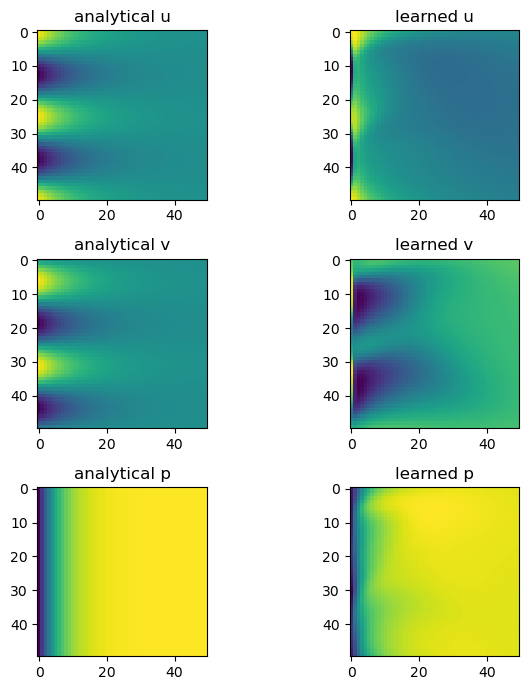

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(7, 7))
axs[0, 0].imshow(u_test)
axs[0, 0].set_title('analytical u')
axs[1, 0].imshow(v_test)
axs[1, 0].set_title('analytical v')
axs[2, 0].imshow(p_test)
axs[2, 0].set_title('analytical p')
axs[0, 1].imshow(u_pred)
axs[0, 1].set_title('learned u')
axs[1, 1].imshow(v_pred)
axs[1, 1].set_title('learned v')
axs[2, 1].imshow(p_pred)
axs[2, 1].set_title('learned p')
fig.tight_layout()

In [13]:
params = pinn.state_dict()
print(params.keys())

odict_keys(['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'layer3.weight', 'layer3.bias', 'layer4.weight', 'layer4.bias', 'layer5.weight', 'layer5.bias', 'layer6.weight', 'layer6.bias', 'output_layer.weight', 'output_layer.bias'])


In [14]:
flattened_weights = []
for key in params.keys():
    flattened_tensor = torch.reshape(params[key], (-1,)).tolist()
    for val in flattened_tensor:
        flattened_weights.append(val)
weights_array = np.array(flattened_weights)
np.savetxt('data/weights/weights_'+str(Re)+'.txt', weights_array)